In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [16]:
col_names = ['unit_number', 'time_in_cycles', 'op_setting_1', 'op_setting_2', 'op_setting_3']
sensor_cols = [f'sensor_{i}' for i in range(1, 22)]
all_columns = col_names + sensor_cols

In [17]:
df = pd.read_csv(r"C:\Users\HP\Desktop\Extion Projects\Predictive Maintenance in Manufacturing\CMaps\test_FD001.txt", sep=r"\s+", header=None)
df.columns = all_columns
print(df.head())

   unit_number  time_in_cycles  op_setting_1  op_setting_2  op_setting_3  \
0            1               1        0.0023        0.0003         100.0   
1            1               2       -0.0027       -0.0003         100.0   
2            1               3        0.0003        0.0001         100.0   
3            1               4        0.0042        0.0000         100.0   
4            1               5        0.0014        0.0000         100.0   

   sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  ...  sensor_12  \
0    518.67    643.02   1585.29   1398.21     14.62  ...     521.72   
1    518.67    641.71   1588.45   1395.42     14.62  ...     522.16   
2    518.67    642.46   1586.94   1401.34     14.62  ...     521.97   
3    518.67    642.44   1584.12   1406.42     14.62  ...     521.38   
4    518.67    642.51   1587.19   1401.92     14.62  ...     522.15   

   sensor_13  sensor_14  sensor_15  sensor_16  sensor_17  sensor_18  \
0    2388.03    8125.55     8.4052       0.03

In [18]:
rul_df = df.groupby('unit_number')['time_in_cycles'].max().reset_index()
rul_df.columns = ['unit_number', 'max_cycle']
df = df.merge(rul_df, on='unit_number')
df['RUL'] = df['max_cycle'] - df['time_in_cycles']
df.drop('max_cycle', axis=1, inplace=True)
print(df[['unit_number', 'time_in_cycles', 'RUL']].head(10))

   unit_number  time_in_cycles  RUL
0            1               1   30
1            1               2   29
2            1               3   28
3            1               4   27
4            1               5   26
5            1               6   25
6            1               7   24
7            1               8   23
8            1               9   22
9            1              10   21


In [ ]:
# Identify sensor columns
sensor_cols = [col for col in df.columns if "sensor_" in col]

drop_cols = [col for col in sensor_cols if df[col].std() < 0.01]
print("Dropped columns:", drop_cols)

# Drop columns with low variance
df.drop(columns=drop_cols, inplace=True)

# Normalize the feature columns
feature_cols = ['op_setting_1', 'op_setting_2', 'op_setting_3'] + [col for col in sensor_cols if col not in drop_cols]

scaler = MinMaxScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])

print(df[feature_cols].head())


Dropped columns: []
   op_setting_1  op_setting_2  op_setting_3  sensor_2  sensor_3  sensor_4  \
0       0.65625      0.692308           0.0  0.596215  0.421968  0.282214   
1       0.34375      0.230769           0.0  0.182965  0.504025  0.225240   
2       0.53125      0.538462           0.0  0.419558  0.464814  0.346130   
3       0.77500      0.461538           0.0  0.413249  0.391587  0.449867   
4       0.60000      0.461538           0.0  0.435331  0.471306  0.357974   

   sensor_7  sensor_8  sensor_9  sensor_11  sensor_12  sensor_13  sensor_14  \
0  0.608871  0.365854  0.196475   0.273973   0.534247   0.325581   0.152259   
1  0.800403  0.292683  0.229042   0.479452   0.634703   0.395349   0.277907   
2  0.651210  0.390244  0.248506   0.479452   0.591324   0.325581   0.192892   
3  0.643145  0.341463  0.159080   0.328767   0.456621   0.372093   0.217896   
4  0.661290  0.292683  0.153410   0.349315   0.632420   0.325581   0.187891   

   sensor_15  sensor_17  sensor_20  sensor

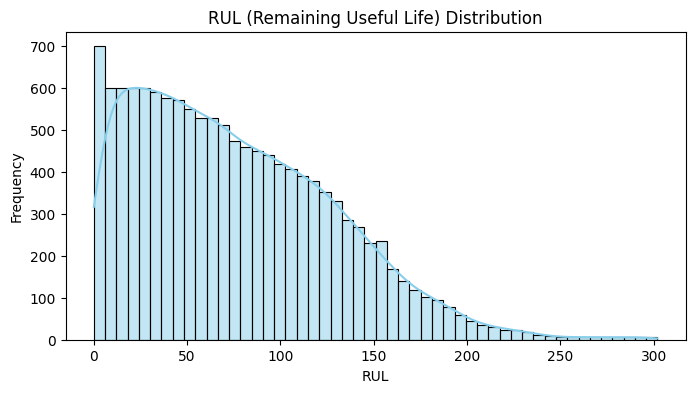

In [21]:
plt.figure(figsize=(8,4))
sns.histplot(df['RUL'], bins=50, kde=True, color='skyblue')
plt.title("RUL (Remaining Useful Life) Distribution")
plt.xlabel("RUL")
plt.ylabel("Frequency")
plt.show()


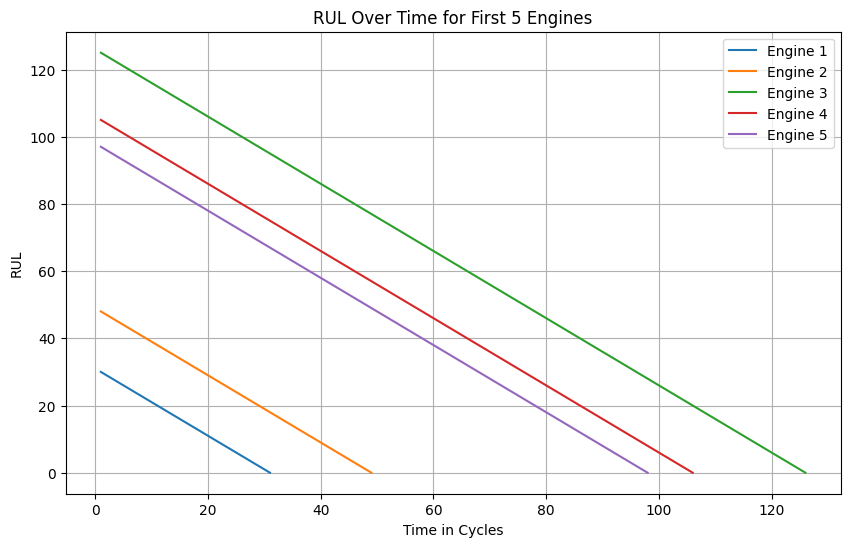

In [20]:
plt.figure(figsize=(10, 6))
for unit in df['unit_number'].unique()[:5]:
    temp = df[df['unit_number'] == unit]
    plt.plot(temp['time_in_cycles'], temp['RUL'], label=f'Engine {unit}')
plt.title("RUL Over Time for First 5 Engines")
plt.xlabel("Time in Cycles")
plt.ylabel("RUL")
plt.legend()
plt.grid()
plt.show()

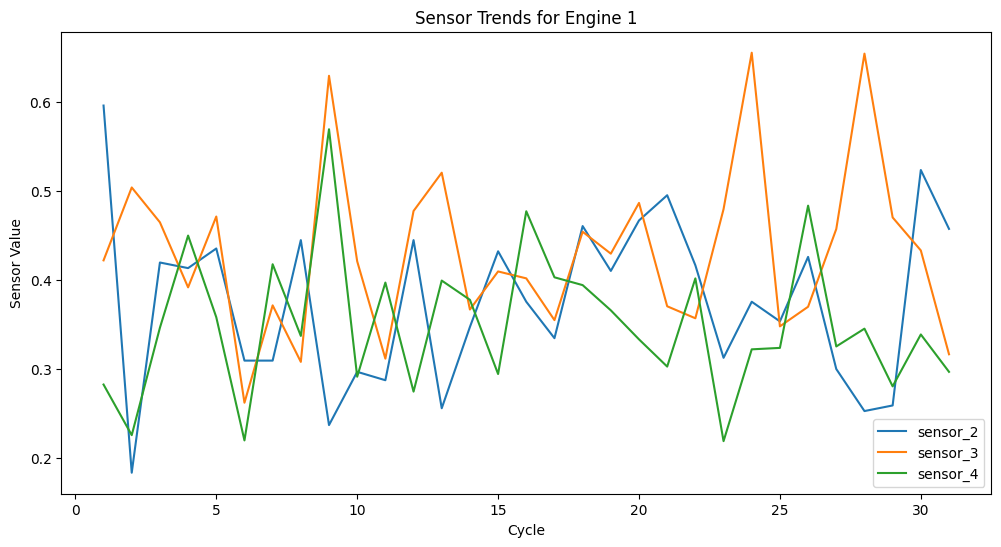

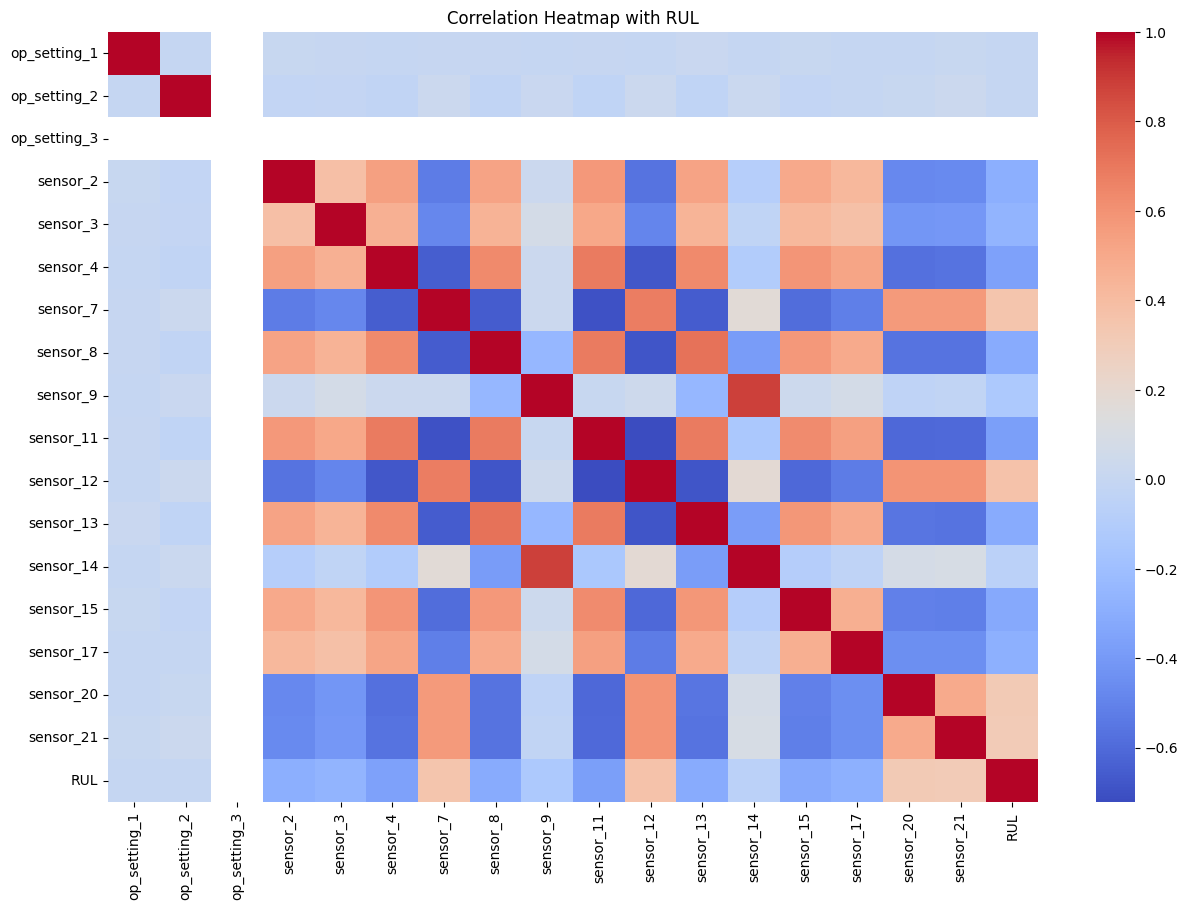

In [ ]:
sample_engine = df[df['unit_number'] == 1]

plt.figure(figsize=(12,6))
for sensor in ['sensor_2', 'sensor_3', 'sensor_4']:  
    plt.plot(sample_engine['time_in_cycles'], sample_engine[sensor], label=sensor)
plt.title("Sensor Trends for Engine 1")
plt.xlabel("Cycle")
plt.ylabel("Sensor Value")
plt.legend()
plt.show()

# Correlation Heatmap
plt.figure(figsize=(15,10))
sns.heatmap(df[feature_cols + ['RUL']].corr(), cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap with RUL")
plt.show()

In [24]:
feature_cols = ['op_setting_1', 'op_setting_2', 'op_setting_3'] + [col for col in df.columns if 'sensor_' in col]
X = df[feature_cols]
y = df['RUL']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [28]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

In [29]:
y_pred = model.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Model Evaluation Metrics:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")


Model Evaluation Metrics:
MAE: 37.84
RMSE: 48.17
R² Score: 0.21


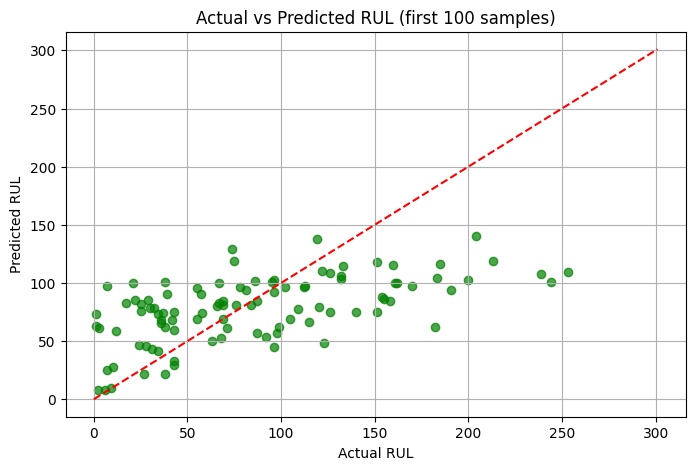

In [30]:
plt.figure(figsize=(8, 5))
plt.scatter(y_test[:100], y_pred[:100], color='green', alpha=0.7)
plt.plot([0, max(y_test)], [0, max(y_test)], '--', color='red')
plt.title("Actual vs Predicted RUL (first 100 samples)")
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.grid()
plt.show()

In [ ]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

xgb_model.fit(X_train_scaled, y_train)

y_pred_xgb = xgb_model.predict(X_test_scaled)


In [32]:
mae = mean_absolute_error(y_test, y_pred_xgb)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2 = r2_score(y_test, y_pred_xgb)


In [33]:
print(f"XGBoost - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.2f}")


XGBoost - MAE: 37.50, RMSE: 47.81, R2: 0.22
